# <font style = "color:rgb(50,120,229)">Recommendation Systems Project</font>

## <font style = "color:rgb(50,120,229)">Data Description</font>

Amazon Reviews data ([data source](http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.

## <font style = "color:rgb(50,120,229)">Domain</font>

E-commerce

## <font style = "color:rgb(50,120,229)">Context</font>

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

## <font style = "color:rgb(50,120,229)">Attribute Information</font>

- `userId` : Every user identified with a unique id
- `productId` : Every product identified with a unique id
- `Rating` : Rating of the corresponding product by the corresponding user
- `timestamp` : Time of the rating ( ignore this column for this exercise)

## <font style = "color:rgb(50,120,229)">Learning Outcomes</font>

- Exploratory Data Analysis
- Creating a Recommendation system using real data
- Collaborative filtering

## <font style = "color:rgb(50,120,229)">Objective</font>

Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

### <font style = "color:rgb(8,133,37)">Step - 0: Import Libraries</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts_sklearn
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split as tts_surprise
%matplotlib inline

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### <font style = "color:rgb(8,133,37)">Step - 1: Read and explore the given dataset</font>

Note that there is no header row in the CSV file so we will have to provide it manually.

In [3]:
# Read the dataset
# File location in Kaggle
#fileLoc = "../input/ratings_Electronics.csv"
# File location in local system
fileLoc = "ratings_Electronics.csv"
df = pd.read_csv(fileLoc,
                 header=None,
                 names=["userId","productId","Rating","timestamp"])

In [4]:
# Check first 5 rows of the dataset
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


We are not going to use the timestamp column in this exercise, so we can drop it.

In [5]:
df.drop("timestamp",axis=1,inplace=True)

In [6]:
# Check first 5 rows of the dataset
df.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


Now that we have successfully read the dataset and fixed the column names, let's explore the data.

In [7]:
df.shape

(7824482, 3)

The dataset has around 7.8M rows and 3 columns.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- `userId` column is of object datatype. We can see from the first 5 rows that the `userId` column is alphanumerical so the object datatype makes sense.
- `productId` column is of object datatype. This is also fine as even though it might look numerical, the 0 at the front matters a lot in this case, so it's better to treat it as a string or an object datatype.
- `Rating` column is already in float datatype which is correct.

In [9]:
# Percentage of missing values in each column
df.isna().sum()/len(df.index) * 100

userId       0.0
productId    0.0
Rating       0.0
dtype: float64

As we can see, there are no missing values in the dataset.

In [10]:
len(df["userId"].unique())

4201696

Note that there are just around 4.2M unique userIds but 7.8M rows which means that some users have given ratings to multiple products.

In [11]:
len(df["productId"].unique())

476002

There are around 0.48M unique productIds (or products).

Let's also check the ratings.

In [12]:
df["Rating"].unique()

array([5., 1., 3., 2., 4.])

Since there are just 5 unique values for ratings and that too whole numbers, we will convert them to integers.

In [13]:
df["Rating"] = df["Rating"].astype("int")

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       int64
dtypes: int64(1), object(2)
memory usage: 179.1+ MB


We can verify from above that the data type of ratings has changed to int.

Let's now try to visualize the distribution of overall product ratings.

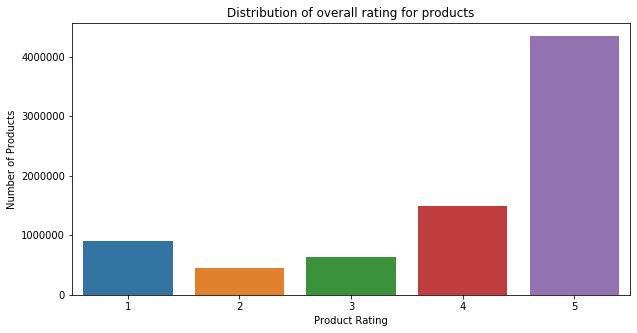

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(df["Rating"])
plt.xlabel("Product Rating")
plt.ylabel("Number of Products")
plt.title("Distribution of overall rating for products")
plt.show()

Note that a very high number of products have got a rating of 5. Whereas a very few products have got a rating from 1 to 3. This shows a skewness in the ratings.

Let's try to understand how many ratings products have got.

In [16]:
df["productId"].value_counts()

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B004P62RUQ        1
B001A1M952        1
B008GYGUA6        1
B004G7N86G        1
B00EEIXMMM        1
Name: productId, Length: 476002, dtype: int64

Note how some products have got a very large number of ratings (10K+) whereas some products have got just 1 rating. 

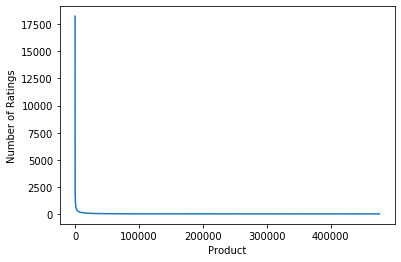

In [17]:
plt.plot(df["productId"].value_counts().values)
plt.xlabel("Product")
plt.ylabel("Number of Ratings")
plt.show()

As we can see from the above plot, there is a huge difference between number of ratings for products.

To make the plot clearer, let's plot the log of number of ratings.

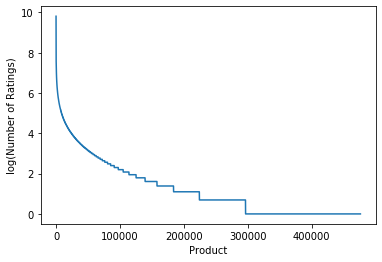

In [18]:
plt.plot(np.log(df["productId"].value_counts().values))
plt.xlabel("Product")
plt.ylabel("log(Number of Ratings)")
plt.show()

The above plots show a skewness in the number of ratings for products.

Let's see a similar distribution for user ratings.

In [19]:
userRatings = df["userId"].value_counts()

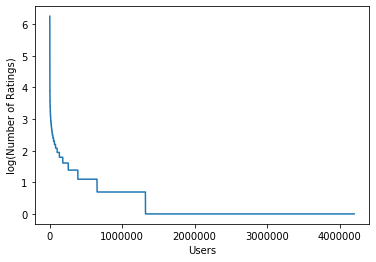

In [20]:
plt.plot(np.log(userRatings.values))
plt.xlabel("Users")
plt.ylabel("log(Number of Ratings)")
plt.show()

The above plot shows a skewness even in number of ratings given by users.

### <font style = "color:rgb(8,133,37)">Step - 2: Take a subset of the data</font>

Take a subset of the dataset to make it less sparse/ denser. We will keep the users only who has given 50 or more number of ratings.

Let's first check the number of users who have given at least 50 ratings.

In [21]:
len(userRatings[userRatings>=50].index)

1540

As we can see, there are 1540 unique users who have given at least 50 ratings.

Let's clean up the dataframe so that only the above 1540 users are taken into account.

In [22]:
# Users who have given at least 50 ratings
usersAbove50Ratings = userRatings[userRatings >= 50].index.values

In [23]:
# Filter dataframe to keep only above users
df = df[df["userId"].isin(usersAbove50Ratings)]

In [24]:
df.shape

(125871, 3)

We have managed to reduce the number of rows to 0.12M from the previous 7.82M.

We can further reduce the data by only considering the products which have at least 10 ratings.

In [25]:
prodRatings = df["productId"].value_counts()

In [26]:
len(prodRatings.index)

48190

In [27]:
len(prodRatings[prodRatings>=10].index)

2263

As we can see, there are just 2263 products with at least 10 ratings.

In [28]:
# Products which have at least 10 ratings
prodsAbove10Ratings = prodRatings[prodRatings >= 10].index.values

In [29]:
# Filter dataframe to keep only above products
df = df[df["productId"].isin(prodsAbove10Ratings)]

In [30]:
df.shape

(42941, 3)

We have managed to reduce the number of rows to 42.9K from the previous 0.12M.

We can now proceed with this dataset.

### <font style = "color:rgb(8,133,37)">Step - 3: Split the dataset</font>

We will split the dataset into train and test dataset with a 70:30 ratio.

In [31]:
train, test = tts_sklearn(df,test_size=0.3,random_state=42)

In [32]:
train.shape

(30058, 3)

In [33]:
test.shape

(12883, 3)

### <font style = "color:rgb(8,133,37)">Step - 4: Popularity Based Recommendations</font>

We will start off by creating a simple popularity based recommendations model which will output the top-K recommendations.

Since we know that there are products which have been given a rating by multiple users, let's sort the mean ratings.

In [34]:
train.groupby("productId")["Rating"].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B001SER47O    5.0
B003B48UQ8    5.0
B0052SCU8U    5.0
B00007IFED    5.0
Name: Rating, dtype: float64

We can convert the above into a function which will output top-K recommendations.

In [35]:
def topK_popularity(K=5):
    topK = train.groupby("productId")["Rating"].mean().sort_values(ascending=False).head(K)
    print("===================================================")
    print("==================TOP {}============================".format(K))
    for i in range(K):
        product = topK.index[i]
        prodRating = topK.iloc[i]
        print("{}.\tProduct: {}\tMean Rating: {}".format(i+1,product,prodRating))
    print("===================================================")
    print("===================================================")
    return topK

In [36]:
# Top-5 recommendations
top5_popularity = topK_popularity(5)

==================TOP 5============================
1.	Product: B00L3YHF6O	Mean Rating: 5.0
2.	Product: B001SER47O	Mean Rating: 5.0
3.	Product: B003B48UQ8	Mean Rating: 5.0
4.	Product: B0052SCU8U	Mean Rating: 5.0
5.	Product: B00007IFED	Mean Rating: 5.0


### <font style = "color:rgb(8,133,37)">Step - 5: Collaborative Filtering Model</font>

Let's first convert the dataframe to surprise Dataset class.

In [37]:
# Reader which will be used for loading Dataset from dataframe
# The rating scale is 1 to 5
reader = Reader(rating_scale=(1,5))
# Surprise dataset
df_sur = Dataset.load_from_df(df[['userId','productId','Rating']],reader)

We will also need to generate train and test set again using surprise package.

In [38]:
train_sur, test_sur = tts_surprise(df_sur, test_size=0.30, random_state=42)

Let's use KNN classifier to find similar products. We will generate both user-user and item-item collaborative filtering models.

In [39]:
# Item-item based collaborative filtering model
item_item = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [40]:
# Fit model
item_item.fit(train_sur)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Similarly, let's create a user-user based collaborative filtering model.

In [41]:
# Item-item based collaborative filtering model
user_user = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})

In [42]:
# Fit model
user_user.fit(train_sur)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Now we have created 2 collaborative filtering models and a popularity based model. Next, let's evaluate the models.

### <font style = "color:rgb(8,133,37)">Step - 6: Evaluate the models</font>

Let's start off with finding RMSE for both collaborative filtering models.

In [43]:
# Find predictions for item-item collaborative model
test_item_item = item_item.test(test_sur)
# Find predictions for user-user collaborative model
test_user_user = user_user.test(test_sur)

In [44]:
# Find RMSE for both models
print("User-user Collaborative Filtering Model : Test Set")
accuracy.rmse(test_item_item, verbose=True)
print("Item-item Collaborative Filtering Model : Test Set")
accuracy.rmse(test_user_user, verbose=True);

User-user Collaborative Filtering Model : Test Set
RMSE: 0.9961
Item-item Collaborative Filtering Model : Test Set
RMSE: 0.9929


Next, let's find the RMSE for the popularity based model.

In [45]:
# Sorted popularity based movies
sorted_pop = train.groupby("productId")["Rating"].mean().sort_values(ascending=False)

We will create a new column with the expected ratings of the movie.

In [46]:
def expectedRating(movie):
    # If the movie is in the
    # sorted popularity based movies
    # dataframe, then return the
    # corresponding rating
    # Otherwise, return 0
    try:
        return sorted_pop[movie]
    except:
        return 0

In [47]:
# Add a new column with expected rating
test["Expected"] = test["productId"].apply(expectedRating)

In [48]:
test.head()

,userId,productId,Rating,Expected
2201866,A22CW0ZHY3NJH8,B001OQC0H0,4,4.111111
3718471,A2BYV7S1QP2YIG,B003ZUIHY8,5,4.461538
6243857,A20L63B48RPSOH,B008I21EA2,5,4.062500
6978022,ABQWMANK4AR63,B00AXVXXNC,4,4.500000
7571971,A2W9I628I6SE1U,B00EVWXAEQ,4,4.285714


In [49]:
# Calculate RMSE of ratings
test["error"] = (test["Rating"] - test["Expected"])**2

In [50]:
test.head()

,userId,productId,Rating,Expected,error
2201866,A22CW0ZHY3NJH8,B001OQC0H0,4,4.111111,0.012346
3718471,A2BYV7S1QP2YIG,B003ZUIHY8,5,4.461538,0.289941
6243857,A20L63B48RPSOH,B008I21EA2,5,4.062500,0.878906
6978022,ABQWMANK4AR63,B00AXVXXNC,4,4.500000,0.250000
7571971,A2W9I628I6SE1U,B00EVWXAEQ,4,4.285714,0.081633


In [51]:
print("Total RMSE: {:.4f}".format(np.sqrt(test["error"].sum()/len(test.index))))

Total RMSE: 0.9207


In [52]:
# Drop the Expected and error columns
test.drop(["Expected","error"],axis=1,inplace=True)

### <font style = "color:rgb(8,133,37)">Step - 7: Get top-K recommendations</font>

For the popularity based model, we already have a function for top-5 recommendations and these recommendations can be used for new users.

In [53]:
topK_popularity(K=5);

==================TOP 5============================
1.	Product: B00L3YHF6O	Mean Rating: 5.0
2.	Product: B001SER47O	Mean Rating: 5.0
3.	Product: B003B48UQ8	Mean Rating: 5.0
4.	Product: B0052SCU8U	Mean Rating: 5.0
5.	Product: B00007IFED	Mean Rating: 5.0


We cannot use collaborative filtering model for finding top-5 recommendations for new users due to the absence of past data. In such cases, we can go for a hybrid approach, in which case we can use top-K recommendations from popularity based model for cold-start problem and use the collaborative filtering model for the users with past data about movies watched.

### <font style = "color:rgb(8,133,37)">Step - 8: Summarise Insights</font>

1. Collaborative filtering model was able to provide much better accuracy than popularity based model, as expected.
2. Collaborative filtering model suffers from cold-start problem because of absence of past data. In such cases, popularity based model can be used to give recommendations.
3. Even though the model covers a huge number of products, we have dropped significant amount of users and products in initial steps. These products have the potential of being better for a new user than the current recommendations.
4. User-user based collaborative filtering model has a slightly better accuracy than item-item based collaborative filtering model. Despite this, companies like Amazon are using item-item based collaborative filtering model. The reason behind this might be that user based nearest neighbor collaborative filtering model do not scale well for most real-world scenarios.